In [1]:
%matplotlib notebook
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pylab as plt

DATA_DIR = '../data/raw/'

# Import and process data


### Demographics

In [22]:
demographics_raw = pd.read_csv(DATA_DIR + 'pcori_heerman_cohort_Demographics_20170116.csv', 
                               index_col=0, parse_dates=['DOB'], infer_datetime_format=True)
demographics_raw.head()

/Users/fonnescj/anaconda3/envs/dev/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2717: DtypeWarning: Columns (6) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


SEX  RACE ETHNICITY        DOB  DOD   ZIP_CODE
MRN                                                     
28997286    2     7        UN 1958-01-09  NaN  422100000
22710289    2     2        NH 1969-09-11  NaN  370640000
15333065    1     1        NH 1996-12-28  NaN  372060000
11732831    1     2        NH 1991-01-31  NaN  370400000
26724542    2     1        NH 1958-08-19  NaN  421340000

In [23]:
demographics_raw.shape

(529428, 6)

In [24]:
demographics_raw.index.is_unique

True

In [25]:
demographics_raw['male'] = (demographics_raw.SEX==1).astype(int)

In [26]:
demographics_raw['race'] = demographics_raw.RACE.replace(dict(zip(range(1, 8), ['white', 'black', 'native', 'asian', 
                                                     'hispanic', 'other', 'unknown'])))

In [27]:
demographics_raw.race.value_counts()

white       419554
black        52455
unknown      32724
hispanic     13540
asian         9708
other          729
native         718
Name: race, dtype: int64

In [28]:
demographics_raw.ETHNICITY.value_counts()

NH    450556
UN     65332
HL     13540
Name: ETHNICITY, dtype: int64

In [29]:
demographics_raw['hispanic'] = (demographics_raw.ETHNICITY=='HL')
demographics_raw.loc[demographics_raw.ETHNICITY=='UN', 'hispanic'] = np.nan

There are no non-null death dates.

In [30]:
demographics_raw.isnull().mean()

SEX          0.000000
RACE         0.000000
ETHNICITY    0.000000
DOB          0.000000
DOD          1.000000
ZIP_CODE     0.001067
male         0.000000
race         0.000000
hispanic     0.123401
dtype: float64

### Weight data

In [2]:
weight_raw = pd.read_csv(DATA_DIR + 'pcori_heerman_cohort_weight_20170213.csv', 
                         parse_dates=[1], infer_datetime_format=True)
weight_raw.head()

MRN WEIGHT_DATE  WEIGHT  PREGNANCY_INDICATOR
0  7695679  2006-01-27   62.60                    1
1  7695679  2006-02-08   62.60                    1
2  7695679  2006-02-08   62.60                    1
3  7695679  2006-03-08   63.96                    1
4  7695679  2006-10-02   65.77                    1

In [3]:
weight_raw.shape

(8030810, 4)

In [4]:
weight_raw.isnull().mean()

MRN                    0.0
WEIGHT_DATE            0.0
WEIGHT                 0.0
PREGNANCY_INDICATOR    0.0
dtype: float64

Add age to each measurement

In [39]:
weight_age = weight_raw.merge(demographics_raw[['DOB']], left_on='MRN', right_index=True)
weight_age['AGE'] = (weight_age.WEIGHT_DATE - weight_age.DOB).astype('<m8[Y]')

In [40]:
weight_age.head()

MRN WEIGHT_DATE  WEIGHT  PREGNANCY_INDICATOR        DOB   AGE
0  7695679  2006-01-27   62.60                    1 1980-03-22  25.0
1  7695679  2006-02-08   62.60                    1 1980-03-22  25.0
2  7695679  2006-02-08   62.60                    1 1980-03-22  25.0
3  7695679  2006-03-08   63.96                    1 1980-03-22  25.0
4  7695679  2006-10-02   65.77                    1 1980-03-22  26.0

In [41]:
weight_age.AGE.min()

17.0

Index values for individuals with a minimum number of measurements

In [6]:
weight_counts = weight_raw.groupby('MRN')['WEIGHT_DATE'].count()

In [13]:
MIN_MEASUREMENTS = 300
many_weights = weight_counts[weight_counts>MIN_MEASUREMENTS].index.values

In [56]:
filtered_weights = (weight_raw[weight_raw.MRN.isin(many_weights) & (weight_raw.PREGNANCY_INDICATOR==0)]
                        .drop('PREGNANCY_INDICATOR', axis=1))
grouped_weights = filtered_weights.groupby('MRN')

<IPython.core.display.Javascript object>


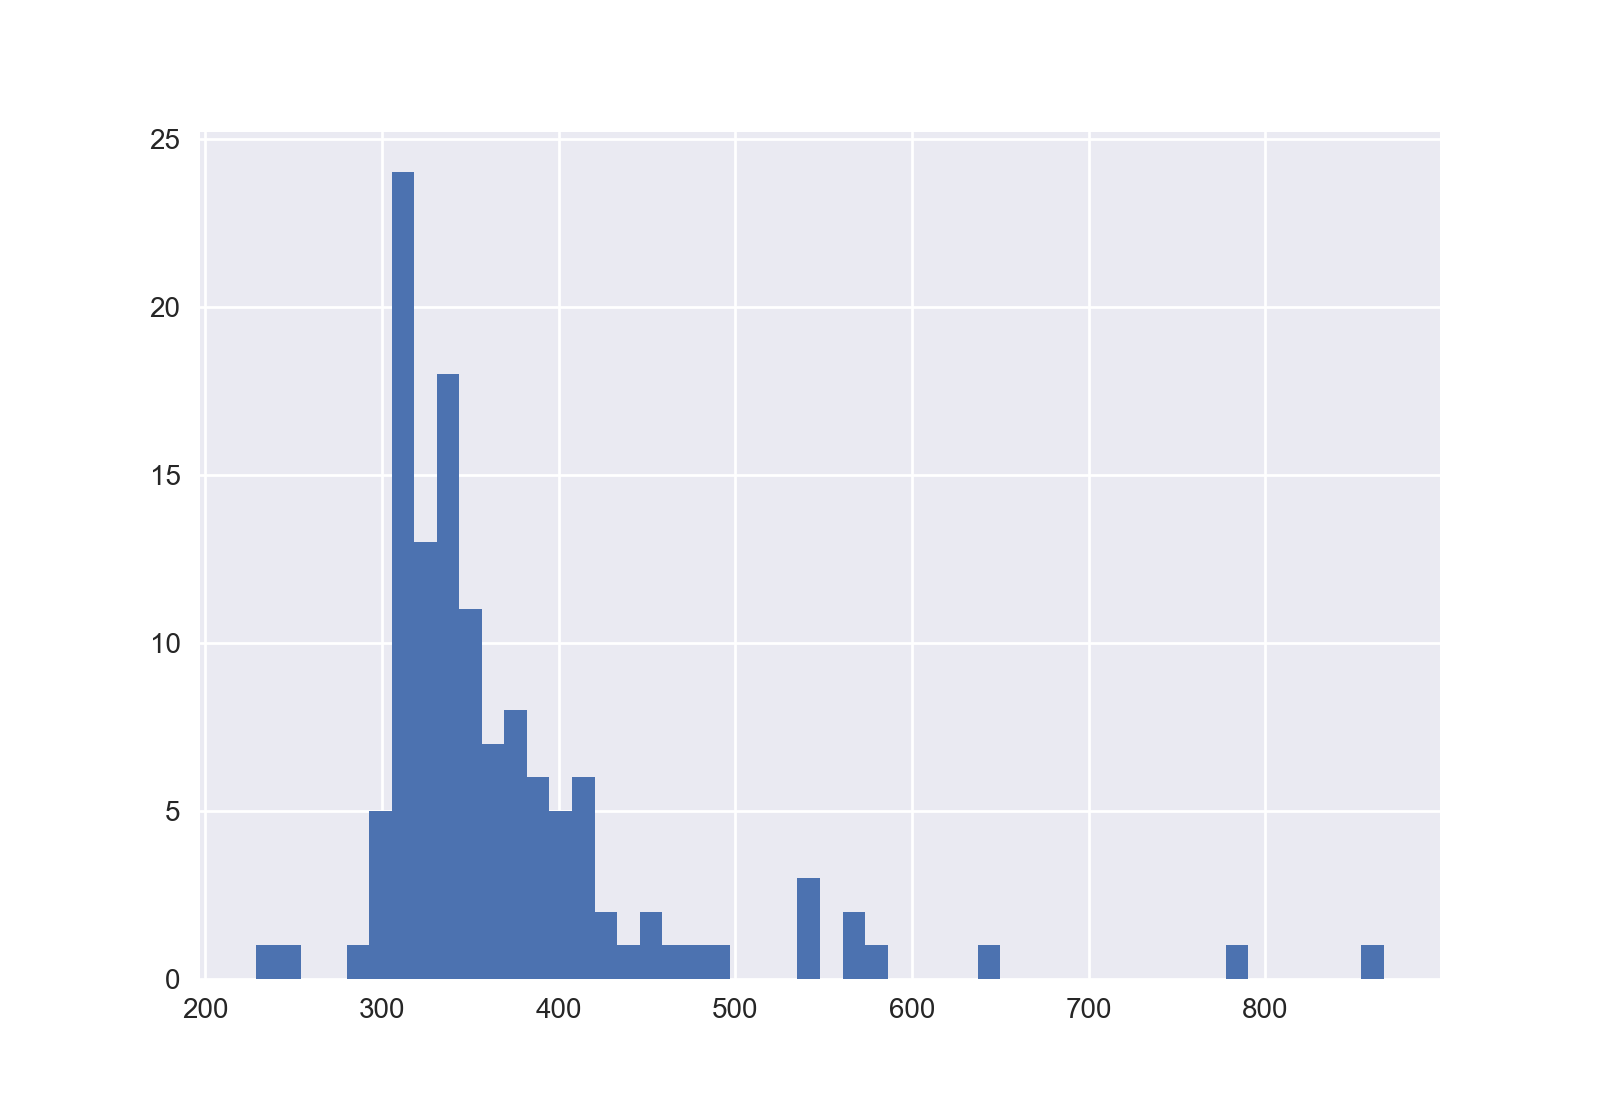

In [19]:
fig, ax = plt.subplots()
grouped_weights['WEIGHT_DATE'].count().hist(bins=50, ax=ax)

In [16]:
weights_by_patient = pd.pivot_table(filtered_weights, 
                                    index='WEIGHT_DATE', columns='MRN', values='WEIGHT')

<IPython.core.display.Javascript object>


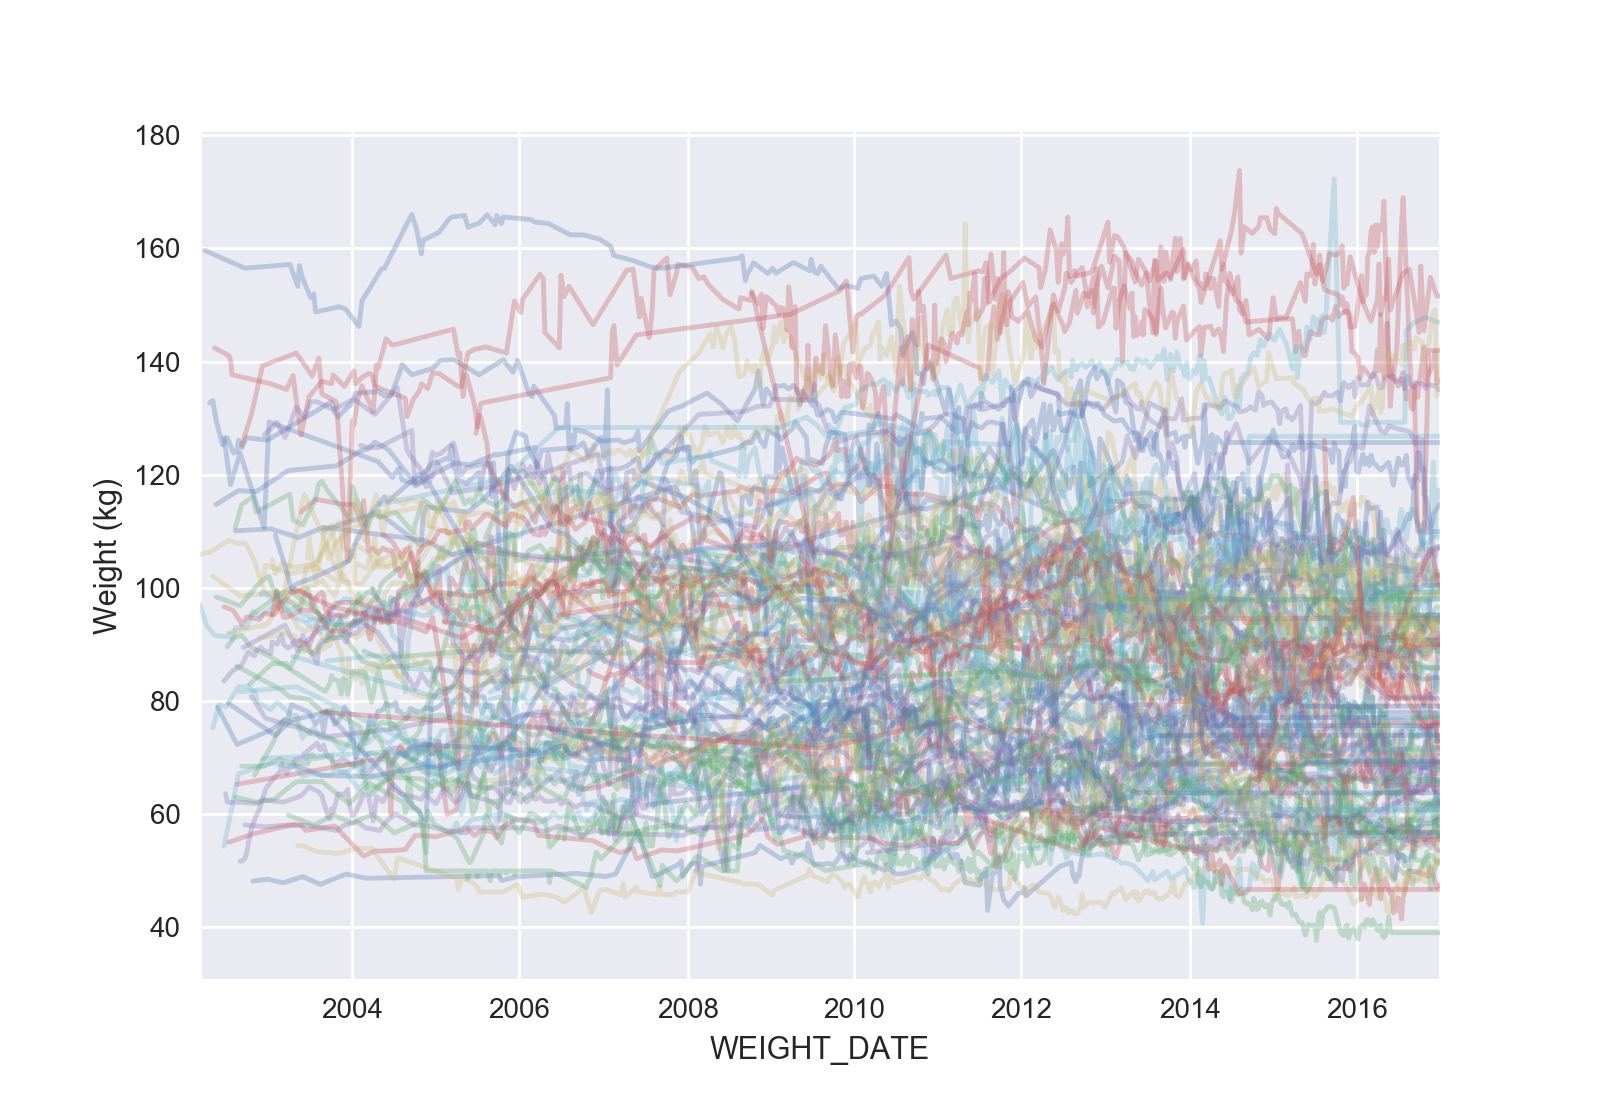

In [21]:
axes = weights_by_patient.resample('W').mean().interpolate().plot(legend=False, alpha=0.3)
axes.set_ylabel('Weight (kg)')

Add a relative date (to first measurement) of each measurement

In [72]:
relative_date = (filtered_weights.groupby('MRN')
         .apply(lambda patient: patient.WEIGHT_DATE - patient.WEIGHT_DATE.min()))
relative_date.index = relative_date.index.droplevel('MRN')
relative_date.head()
relative_date.name = 'RELATIVE_DATE'

In [76]:
weights = pd.concat([filtered_weights, relative_date], axis=1)

In [93]:
weights_by_patient = pd.pivot_table(weights.assign(Days=weights.RELATIVE_DATE.dt.days), 
                                    index='Days', columns='MRN', values='WEIGHT')

<IPython.core.display.Javascript object>


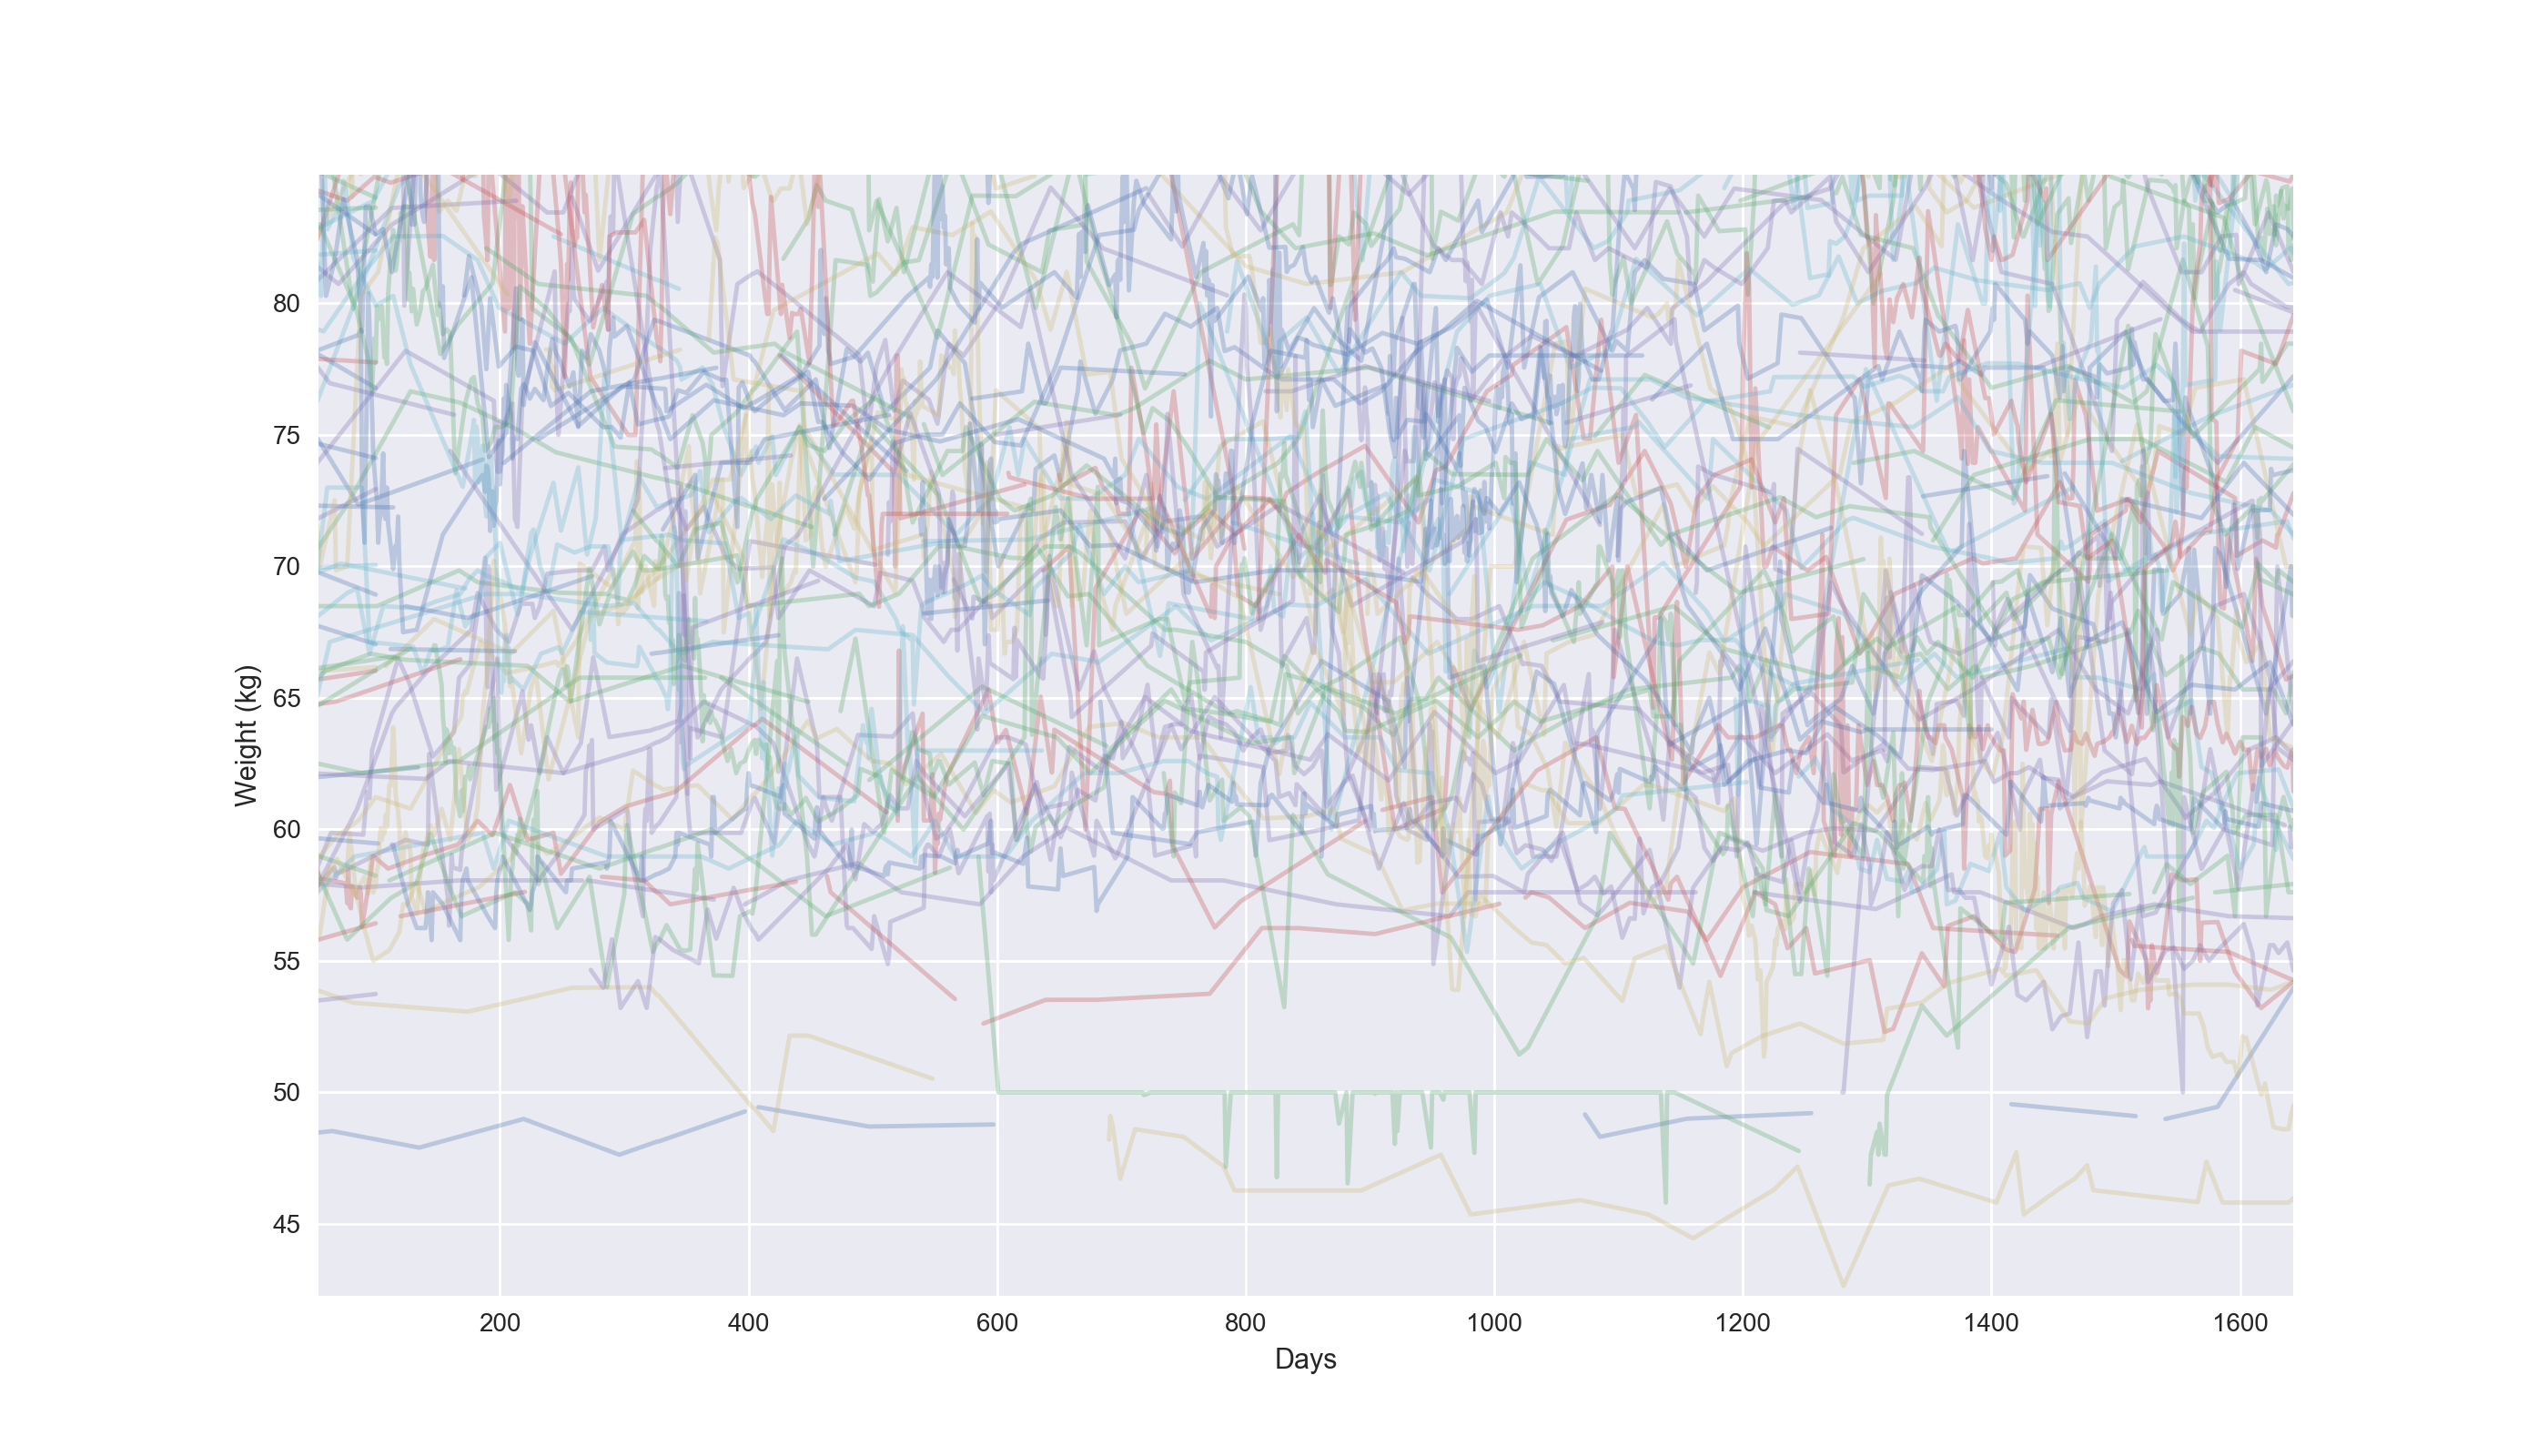

In [96]:
axes = weights_by_patient.interpolate(limit=100).plot(legend=False, alpha=0.3, figsize=(14,8))
axes.set_ylabel('Weight (kg)');

In [97]:
from collections import Counter

In [99]:
x = Counter()

In [100]:
x()

TypeError: 'Counter' object is not callable

### Lab values

In [16]:
lab_raw = pd.read_csv(DATA_DIR + 'pcori_heerman_cohort_Lab_20170213.csv', 
                      usecols = ['MRN','LAB_DATE','LAB_VALUE','LAB_NAME','LAB_UNIT'],
                      parse_dates=[1], infer_datetime_format=True)
lab_raw.head()

MRN    LAB_DATE LAB_VALUE LAB_NAME LAB_UNIT
0  2156149  10/09/2013      1.09    Creat    mg/dL
1  2156149  10/09/2013      1.04    Creat    mg/dL
2  2156149  10/09/2013      0.89    Creat    mg/dL
3  2156149  10/10/2013      0.89    Creat    mg/dL
4  2156149  10/10/2013      0.97    Creat    mg/dL

In [17]:
lab_raw.shape

(8496974, 5)

### ICD codes

In [18]:
icd_raw = pd.read_csv(DATA_DIR + 'pcori_heerman_cohort_ICD_9_10_20170116.csv', 
                      parse_dates=[1], infer_datetime_format=True)
icd_raw.head()

MRN EVENT_DATE ICD_CODE  CODE_TYPE
0  2360139 2003-01-07    401.1          9
1  2360139 2002-01-08    401.1          9
2  2360139 2003-01-08    401.1          9
3  2360139 2005-01-11    401.1          9
4  2360139 2004-01-13    401.9          9

In [19]:
icd_raw.shape

(8796137, 4)

In [20]:
icd_raw.CODE_TYPE.value_counts()

9     7098563
10    1697574
Name: CODE_TYPE, dtype: int64

### Height measurements

Perhaps choose modal or median for each patient.

In [21]:
height_raw = pd.read_csv(DATA_DIR + 'pcori_heerman_cohort_Height_20170213.csv', 
                         parse_dates=[1], infer_datetime_format=True)
height_raw.head()

MRN HEIGHT_DATE  HEIGHT
0  1887330  2016-02-22  157.48
1  1887330  2012-01-17  162.56
2  1887330  2013-02-15  162.56
3  1887330  2013-05-17  162.56
4  1887330  2013-08-07  162.56

In [22]:
height_raw.shape

(4897313, 3)

In [23]:
height_raw.HEIGHT[(height_raw.HEIGHT<200) & (height_raw.HEIGHT>0) ].shape

(4890749,)

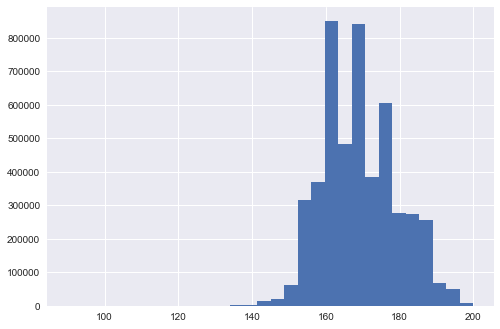

In [25]:
height_raw.HEIGHT[(height_raw.HEIGHT<200) & (height_raw.HEIGHT>0) ].hist(bins=30)

### CPT codes

In [35]:
cpt_raw = pd.read_csv(DATA_DIR + 'pcori_heerman_cohort_CPT_20170116.csv',
                     parse_dates=[1], infer_datetime_format=True)
cpt_raw.head()

MRN   CPT_DATE CPT_CODE
0  31275076 2012-05-29    43775
1  31275076 2012-05-29    43775
2  31275076 2012-05-29    43775
3  31275076 2012-05-29    43775
4  31275076 2012-05-29    43775

In [36]:
cpt_raw.CPT_CODE.value_counts()

43644    17663
33533    14801
43775     6306
33518     3268
43770     2704
33517     2302
33530     1787
35301     1740
43659     1609
33519     1410
43846      830
34802      738
35474      727
37215      701
33510      638
33511      581
43774      555
27886      521
35556      503
35473      451
35226      450
33512      447
35646      368
35371      330
33534      317
43847      303
27596      246
43633      238
35566      230
33521      228
         ...  
35565       27
43888       26
34804       23
35495       23
35454       21
34805       20
35585       19
43887       16
35355       14
25909       13
25927       12
35583       11
35456        9
35671        9
35563        7
35546        6
35663        6
35459        6
35483        5
35381        5
35492        3
33523        3
35548        2
35651        2
35485        2
25931        2
0076T        1
35551        1
25924        1
35482        1
Name: CPT_CODE, dtype: int64

In [37]:
cpt_raw.isnull().mean()

MRN         0.0
CPT_DATE    0.0
CPT_CODE    0.0
dtype: float64

In [38]:
demographics_raw.merge(cpt_raw, left_index=True, right_on='MRN', how='inner').shape

(65769, 12)

## Data processing

Apply Greevy algorithm to weight data.

- how does the distribution change after applying filter?
- add updated flags from Shenghua

Start by aligning data to first weight measurement.

Remove short trajectories for initial model fitting.